### Auto Regressive Integratred Moving Average (ARIMA) Model
ARIMA model can be used to predict the future values based on its own past values, that is, its own lags (Auto Regressive)  and the lagged forecast errors (Moving Average). [Complete Guide in this link](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#:~:text=ARIMA%2C%20short%20for%20'Auto%20Regressive,used%20to%20forecast%20future%20values). Also refer to this [Youtube link about ARIMA Models for Stock Price Prediciton](https://www.youtube.com/watch?v=gqryqIlvEoM&ab_channel=DecisionForest) for clear explanation.

Here we use it for forecasting stock price.

#### Importing Extensions and  main Libraries
I will be importing libraries in the notebook cell as needed to make it clear where it is exactly needed.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

import warnings

warnings.filterwarnings("ignore")

plt.style.use(style="seaborn")
%matplotlib inline

# make autocomplet working
%config Completer.use_jedi = False

In [3]:
# data is microsoft's past 6 months daily stock price (October 11 2020 - April 10 2021)
data_url = "https://query1.finance.yahoo.com/v7/finance/download/MSFT?period1=1602374400&period2=1618099200&interval=1d&events=history&includeAdjustedClose=true"
data = pd.read_csv(data_url)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-10-12,218.789993,223.860001,216.809998,221.399994,220.314453,40461400
1,2020-10-13,222.720001,225.210007,220.429993,222.860001,221.767288,28950800
2,2020-10-14,223.000000,224.220001,219.130005,220.860001,219.777100,23451700
3,2020-10-15,217.100006,220.360001,216.009995,219.660004,218.582993,22733100
4,2020-10-16,220.149994,222.289993,219.320007,219.660004,218.582993,26057900
...,...,...,...,...,...,...,...
119,2021-04-05,242.759995,249.960007,242.699997,249.070007,249.070007,36910600
120,2021-04-06,247.610001,249.399994,246.880005,247.860001,247.860001,22931900
121,2021-04-07,247.809998,250.929993,247.190002,249.899994,249.899994,22719800
122,2021-04-08,252.770004,254.139999,252.000000,253.250000,253.250000,23625200


In [4]:
# making it univariate time series problem, we are taking the Closing price to predict
df = data[["Close"]].round(2).copy()
print(df.shape)
df.head()

(124, 1)


,Close
0,221.40
1,222.86
2,220.86
3,219.66
4,219.66


In [5]:
df.describe()

,Close
count,124.000000
mean,225.338629
std,12.267210
min,202.330000
25%,214.920000
50%,222.805000
75%,235.295000
max,255.850000


##### ARIMA model is characterized by 3 terms: p,d and q
- p is the order of the AR term
- q is the order of the MA term
- d is the number of differencing required to make the time series stationary

**If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’**

#### lets find d first
- The purpose of differencing is to make the time series stationary. Differencing is only needed if the series is non-stationary.
- [Augmented Dickey Fuller (ADF)](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/) can be used to check if the series is stationary or not. 
- The null hypothesis of the **ADF test** is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary. So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [6]:
# Check if price series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -0.65216025177646
p-value: 0.8587551542195173


Since, the values is greater, lets difference the series and see how the auto-correlation plot looks like using **Autocorrelation Function (ACF)**

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

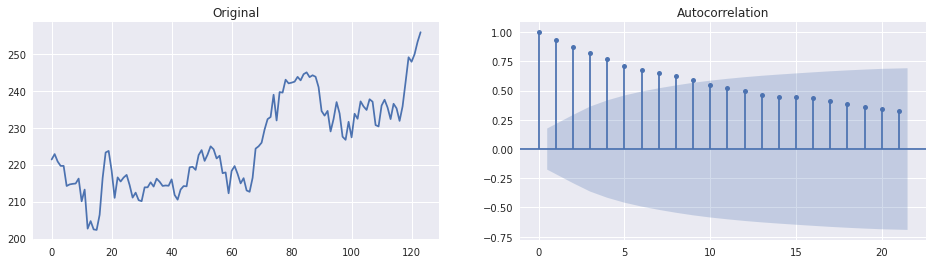

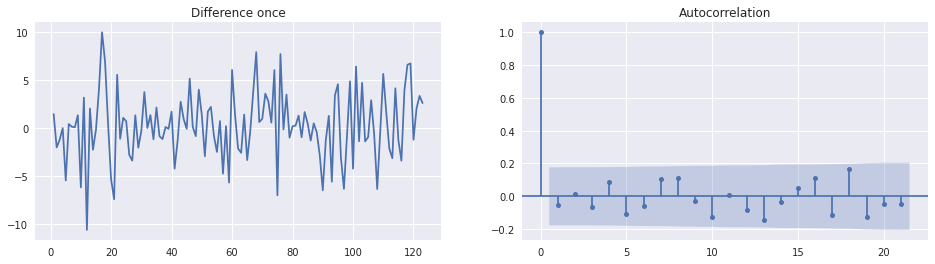

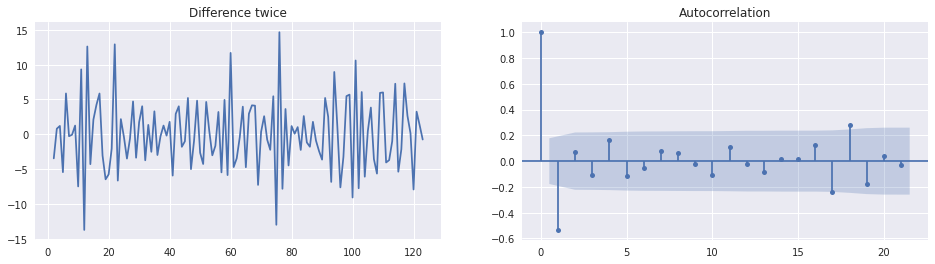

In [8]:
# # add ; at the end of the plot function so that the plot is not duplicated
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df.Close)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df.Close, ax=ax2)

# 1st Differencing
diff = df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2)

# 2nd Differencing
diff = df.Close.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2)

It can be difficult to analyze the plot, so lets use `pmdarima package` to get the number of indexing. [pmdarima docs](http://alkaline-ml.com/pmdarima/modules/classes.html)

In [9]:
from pmdarima.arima.utils import ndiffs

ndiffs(df.Close, test="adf")

1

Ok, so according to pmdarima, lets use the value of d as 1.

#### Now, lets find p
p in ARIMA model is the order of the Auto Regressive (AR) term which refers to lags to be used as predictors. This can be calculated by inspecting the partial Autocorrelation (PACF) plot.

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

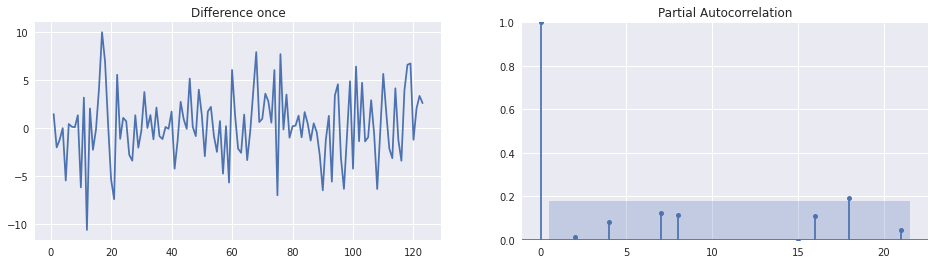

In [11]:
# PACF plot of 1st differenced series
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2)

We can observe that the PACF lag 7 is quite signigicant since is well above the significance line. We can take other points and try to check the result.

#### Now, lets find q 
q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model. We can look at the ACF plot for the number of MA terms.

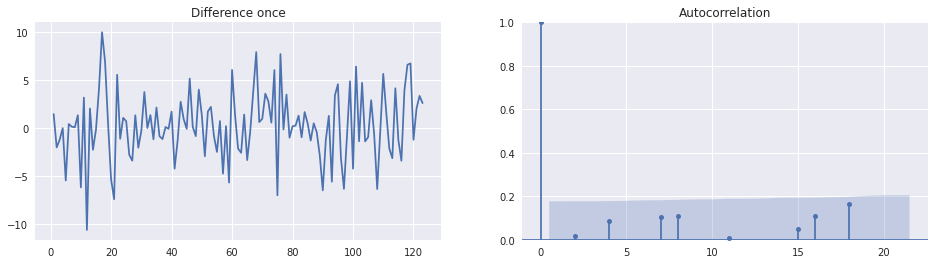

In [12]:
# lets see autocorrelation plot of the 1st differenced series
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)

Couple of lags are well abvoe the significane line, but I am going with 2.

### Fitting the ARIMA model

In [13]:
from statsmodels.tsa.arima_model import ARIMA

In [14]:
# 7,1,2 = p,d,q ARIMA Model
model = ARIMA(df.Close, order=(7, 1, 2))
result = model.fit(disp=0)

In [15]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  123
Model:                 ARIMA(7, 1, 2)   Log Likelihood                -326.157
Method:                       css-mle   S.D. of innovations              3.425
Date:                Sun, 11 Apr 2021   AIC                            674.313
Time:                        12:39:38   BIC                            705.247
Sample:                             1   HQIC                           686.879
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2914      0.317      0.918      0.358      -0.331       0.913
ar.L1.D.Close     0.5043      0.658      0.766      0.443      -0.785       1.794
ar.L2.D.Close    -0.3124      0.256     

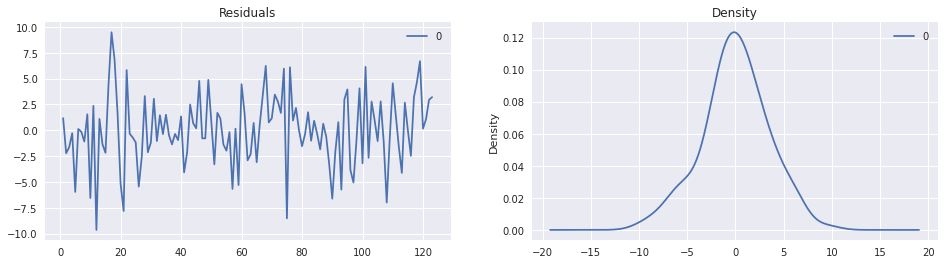

In [16]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind="kde", title="Density", ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values. When we set `dynamic=False` the in-sample lagged values are used for prediction.

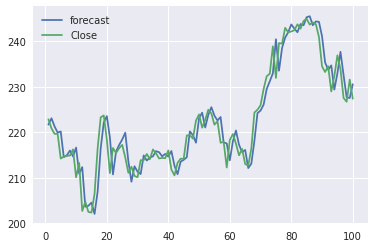

In [17]:
# Actual vs Fitted
result.plot_predict(start=1, end=100, dynamic=False)
plt.show()

After this plot, it looks that the model predicts good output but is it the best ? We can't say that at this point because we haven't forecasted into the future and compare the forecast and the actual performance. Let's use out-of-time cross validation to achieve that.

#### Optimal ARIMA model manually using Out-of-Time Cross Valiation
Steps that needs to be taken for this approach.
- Split the data into train test. 
- Lets do 80:20 ratio and the splitting must be continuous (not random/shuffling) because the order sequence of the time series should be intact in order to use it for forecasting.

In [18]:
# train test split
n = int(len(df) * 0.8)
train = df.Close[:n]
test = df.Close[n:]
print(len(train), len(test))

99 25


In [21]:
step = 25

model = ARIMA(train, order=(6, 1, 3))
result = model.fit(disp=0)
print(result.summary())

# Forecast
fc, se, conf = result.forecast(step)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                   98
Model:                 ARIMA(6, 1, 3)   Log Likelihood                -257.477
Method:                       css-mle   S.D. of innovations              3.276
Date:                Sun, 11 Apr 2021   AIC                            536.953
Time:                        12:40:44   BIC                            565.388
Sample:                             1   HQIC                           548.455
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0421      0.357      0.118      0.906      -0.658       0.742
ar.L1.D.Close     0.9387      0.504      1.863      0.062      -0.049       1.926
ar.L2.D.Close    -0.1241      0.714     

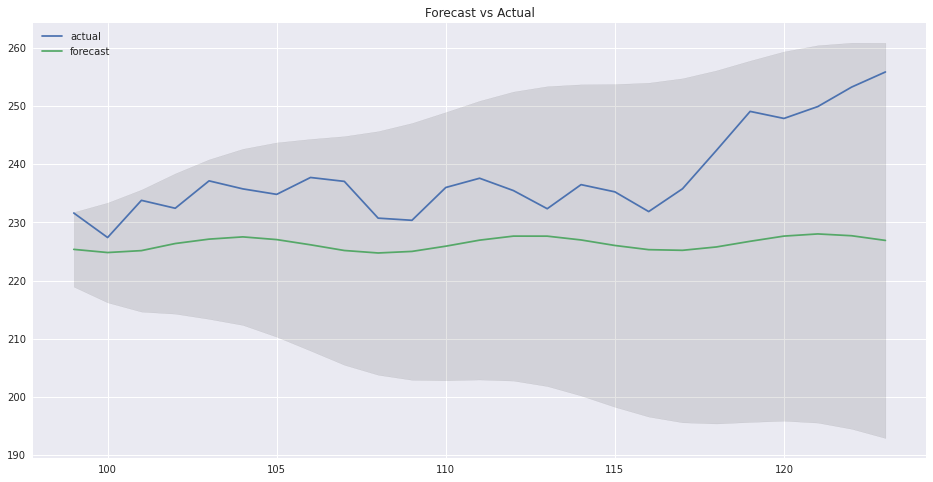

In [22]:
fc = pd.Series(fc, index=test[:step].index)
lower = pd.Series(conf[:, 0], index=test[:step].index)
upper = pd.Series(conf[:, 1], index=test[:step].index)

plt.figure(figsize=(16, 8))
plt.plot(test[:step], label="actual")
plt.plot(fc, label="forecast")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
plt.title("Forecast vs Actual")
plt.legend(loc="upper left")
plt.show()

From the figure above, the forecast direction is correct, the actual observed value more or less lies with the 95% confidence support. But, the predicted forecast is considerably below the actual. More trail and error is needed to make the better forecast.

### Accuracy metrics for the Time Series Forecast
Generally, we use the following metrics to evaluate the time series.
- Mean Absolute Percentage Error (MAPE)
- Correlation
- Min-Max Error
The reason behind using these metrics is that, these are percentage errors that vary form 0 an 1 so we can evaluate how good or bad the forecase is irrespective of the scale of the series.

In [23]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    corr = np.corrcoef(forecast, actual)[0, 1]  # corr
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins / maxs)  # minmax

    return {"mape": mape, "corr": corr, "minmax": minmax}


forecast_accuracy(fc, test[:step])

{'mape': 0.04778798833579569,
 'corr': 0.5720213377778345,
 'minmax': 0.04778798833579567}

Well, around 4.7% MAPE implies the mode is 95.3% accurate in predicting the next 25 observations. This model is far from perfect. But let us leave as it is for now as it is not going in production and this is just to practice purpose. Lets see how auto ARIMA performs next.

#### Auto ARIMA
The `pmdarima package` provides an auto_arima method that uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC. Lets try this auto ARIMA to see what it captures.

In [24]:
from pmdarima.arima import auto_arima

In [25]:
model = auto_arima(
    df.Close,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=3,
    max_q=3,
    m=1,
    d=None,
    seasonal=False,
    trace=True,
    stepwise=True,
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=666.774, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=663.784, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=665.426, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=665.434, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=662.553, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.226 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  124
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -330.276
Date:                Sun, 11 Apr 2021   AIC                            662.553
Time:                        12:41:46   BIC                            665.365
Sample:                             0   HQIC                           663.695
                                - 124                                         
Co

#### Interpret the residual plots of ARIMA Model

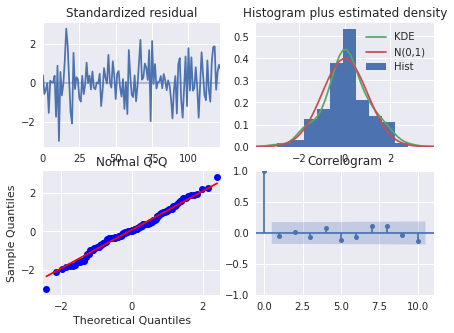

In [26]:
model.plot_diagnostics(figsize=(7, 5))
plt.show()

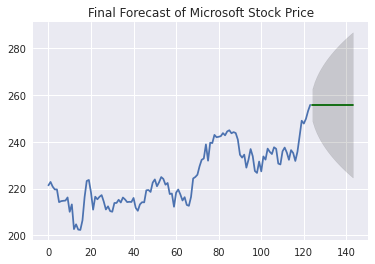

In [29]:
# Forecast
n_periods = 20
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.Close), len(df.Close) + n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.Close)
plt.plot(fc_series, color="darkgreen")
plt.fill_between(lower_series.index, lower_series, upper_series, color="k", alpha=0.15)

plt.title("Final Forecast of Microsoft Stock Price")
plt.show()

##### Well, the forecast doesn't seems to be perfect, which leaves more room for learning and exploring new stuffs.